<a href="https://colab.research.google.com/github/sidharkal/Massachusetts-Roads/blob/main/massachusetts_roads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle integration

In [1]:
!rm -rf road_segmentation_ideal

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sidharkal","key":"eedd46e88010f4e8e66d777ce5320f47"}'}

In [5]:
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

# Downloading data and unzipping it

In [6]:
!kaggle datasets download -d insaff/massachusetts-roads-dataset

100% 4.71G/4.72G [01:36<00:00, 22.9MB/s]
100% 4.72G/4.72G [01:36<00:00, 52.4MB/s]


In [7]:
!unzip \*.zip

Archive:  massachusetts-roads-dataset.zip
  inflating: road_segmentation_ideal/testing/input/img-1.png  
  inflating: road_segmentation_ideal/testing/input/img-10.png  
  inflating: road_segmentation_ideal/testing/input/img-11.png  
  inflating: road_segmentation_ideal/testing/input/img-12.png  
  inflating: road_segmentation_ideal/testing/input/img-13.png  
  inflating: road_segmentation_ideal/testing/input/img-2.png  
  inflating: road_segmentation_ideal/testing/input/img-3.png  
  inflating: road_segmentation_ideal/testing/input/img-4.png  
  inflating: road_segmentation_ideal/testing/input/img-5.png  
  inflating: road_segmentation_ideal/testing/input/img-6.png  
  inflating: road_segmentation_ideal/testing/input/img-7.png  
  inflating: road_segmentation_ideal/testing/input/img-8.png  
  inflating: road_segmentation_ideal/testing/input/img-9.png  
  inflating: road_segmentation_ideal/testing/output/img-1.png  
  inflating: road_segmentation_ideal/testing/output/img-10.png  
  infl

# Importing Library

In [8]:
import os
import numpy as np
from glob import glob
import tensorflow as tf
import os

In [16]:
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import cv2

plt.style.use("ggplot")
%matplotlib inline
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from imgaug import augmenters as iaa
print("Imported all the dependencies")


Imported all the dependencies


In [9]:
os.getcwd()

'/content'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
!pip install split-folders
import splitfolders
Data=r"/content/road_segmentation_ideal/training"
if not os.path.exists('road_segmentation_ideal/data'):
  os.makedirs('road_segmentation_ideal/data')
splitfolders.ratio(Data, output="road_segmentation_ideal/data", seed=1337, ratio=(0.8, 0.2))

Copying files: 1909 files [01:41, 18.79 files/s]


In [11]:
!rm massachusetts-roads-dataset.zip

# Loading data

In [12]:
path = '/content/road_segmentation_ideal/data/train/'

In [13]:
def load_data(path):
    images = sorted(glob(os.path.join(path, "input/*")))
    masks = sorted(glob(os.path.join(path, "output/*")))

    return images, masks
images, masks = load_data(path)
print(f"Images: {len(images)} - Masks: {len(masks)}")    

Images: 884 - Masks: 643


In [14]:
def get_images_with_mask(lst1, lst2):
  lst3 = [value for value in lst1 if value in lst2]
  return lst3


#training dataset
training_input = next(os.walk("/content/road_segmentation_ideal/data/train/input"))[2]
training_output = next(os.walk("/content/road_segmentation_ideal/data/train/output"))[2]

images_with_mask = get_images_with_mask(training_input, training_output)

training_images = []
training_masks = []
for i in images_with_mask:
  a = "/content/road_segmentation_ideal/data/train/input/" + str(i)
  b = "/content/road_segmentation_ideal/data/train/output/" + str(i)
  training_images.append(a)
  training_masks.append(b)   

testing_input = next(os.walk("/content/road_segmentation_ideal/data/val/input"))[2]
testing_output = next(os.walk("/content/road_segmentation_ideal/data/val/output"))[2]


#test dataset
images_with_mask = get_images_with_mask(testing_input, testing_output)

testing_images = []
testing_masks = []
for i in images_with_mask:
  a = "/content/road_segmentation_ideal/data/val/input/" + str(i)
  b = "/content/road_segmentation_ideal/data/val/output/" + str(i)
  testing_images.append(a)
  testing_masks.append(b)       

# loading and preprocessing 

In [17]:

from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                       val_shift_limit=10, p=.9),
    # CLAHE(p=1.0, clip_limit=2.0),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    ToFloat(max_value=255)
])

AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])



In [18]:
def load_image(filename,size,channel):
  image_string = tf.io.read_file(filename)

  #Don't use tf.image.decode_image, or the output shape will be undefined
  image = tf.image.decode_png(image_string, channels=channel)
  #This will convert to float values in [0, 1]
  image = tf.image.convert_image_dtype(image, tf.float32)
  resized_image = tf.image.resize(image, [img_size, img_size]) 
  return resized_image

def preprocess(x, y):
  images = load_image(x,img_size,3)
  masks = load_image(y,img_size,1)
  return images, masks

def load_train_dataset(x, y,batch=8):

  from albumentations import (Compose, RandomBrightness, JpegCompression, HueSaturationValue,
 RandomContrast, HorizontalFlip,Rotate)
  AUTOTUNE = tf.data.experimental.AUTOTUNE
  AUTOTUNE = tf.data.AUTOTUNE
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.cache()
  dataset = dataset.repeat()
  dataset = dataset.shuffle(buffer_size=1000)
  dataset = dataset.map(preprocess)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(AUTOTUNE)
  return dataset    

def load_test_dataset(x, y,batch=8):
  from albumentations import (Compose, RandomBrightness, JpegCompression, HueSaturationValue,
 RandomContrast, HorizontalFlip,Rotate)
  AUTOTUNE = tf.data.experimental.AUTOTUNE
  AUTOTUNE = tf.data.AUTOTUNE
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.map(preprocess)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(AUTOTUNE)
  return dataset      


batch_size = 8
img_size = 512
img_height = 512
img_width = 512
STEPS_PER_EPOCH = len(training_images) // batch_size

training_dataset = load_train_dataset(training_images, training_masks)

testing_dataset = load_test_dataset(testing_images, testing_masks)  

In [19]:
for image, mask in training_dataset.take(1):
  print(image.shape)
  print(mask.shape)

(8, 512, 512, 3)
(8, 512, 512, 1)


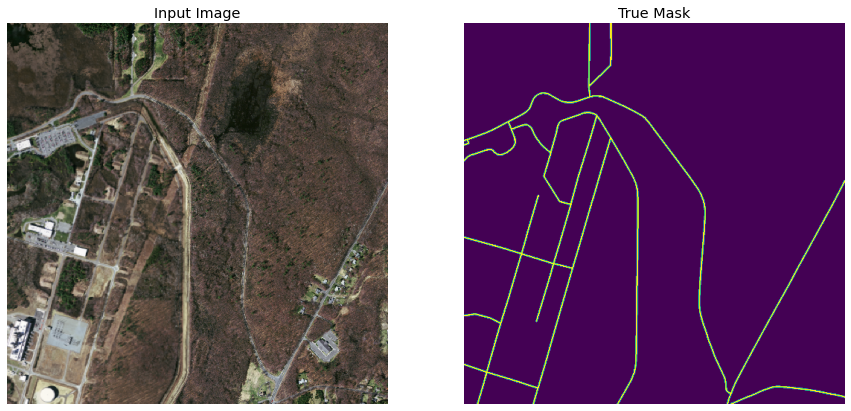

In [20]:
import matplotlib.pyplot as plt
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in training_dataset.take(1):
  sample_image, sample_mask = image, mask
display([sample_image[0], sample_mask[0]])

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

# Dice Coefficient (F1 Score)
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [22]:
# Build the model
inputs = tf.keras.layers.Input((512, 512, 3))
#s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=[iou,tf.keras.metrics.MeanIoU(num_classes=2),dice_coef])

model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
len(testing_images)

36

In [24]:
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(testing_images)//batch_size//VAL_SUBSPLITS
VALIDATION_STEPS=5

model_history = model.fit(training_dataset,epochs=30,steps_per_epoch=64, validation_steps=VALIDATION_STEPS,validation_data=testing_dataset)

Epoch 1/30
64/64 [==============================] - 106s 1s/step - loss: 0.2487 - iou: 0.0278 - mean_io_u: 0.4782 - dice_coef: 0.0500 - val_loss: 0.2618 - val_iou: 0.0632 - val_mean_io_u: 0.4773 - val_dice_coef: 0.1155
Epoch 2/30
64/64 [==============================] - 48s 755ms/step - loss: 0.1854 - iou: 0.0553 - mean_io_u: 0.4785 - dice_coef: 0.0956 - val_loss: 0.1935 - val_iou: 0.0755 - val_mean_io_u: 0.4773 - val_dice_coef: 0.1400
Epoch 3/30
64/64 [==============================] - 46s 713ms/step - loss: 0.1722 - iou: 0.0650 - mean_io_u: 0.4789 - dice_coef: 0.1134 - val_loss: 0.1862 - val_iou: 0.0664 - val_mean_io_u: 0.4773 - val_dice_coef: 0.1306
Epoch 4/30
64/64 [==============================] - 43s 664ms/step - loss: 0.1707 - iou: 0.0781 - mean_io_u: 0.4782 - dice_coef: 0.1350 - val_loss: 0.1803 - val_iou: 0.0864 - val_mean_io_u: 0.4773 - val_dice_coef: 0.1597
Epoch 5/30
64/64 [==============================] - 44s 683ms/step - loss: 0.1584 - iou: 0.0870 - mean_io_u: 0.4794 - 

In [25]:
history_dict = model_history.history
print(history_dict.keys())

dict_keys(['loss', 'iou', 'mean_io_u', 'dice_coef', 'val_loss', 'val_iou', 'val_mean_io_u', 'val_dice_coef'])


# Training Iou and Validation Iou

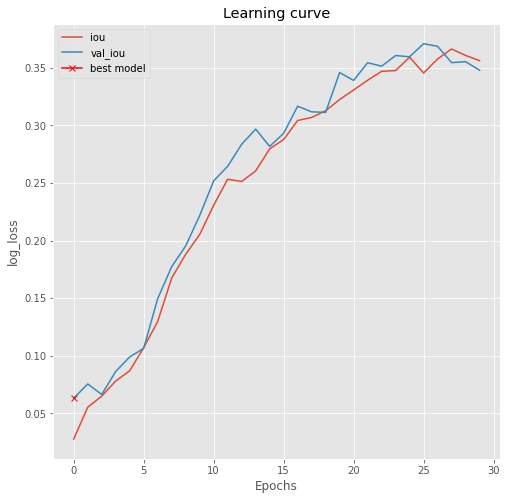

In [26]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_history.history["iou"], label="iou")
plt.plot(model_history.history["val_iou"], label="val_iou")
plt.plot( np.argmin(model_history.history["val_iou"]), np.min(model_history.history["val_iou"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

#  Training loss and Validation loss

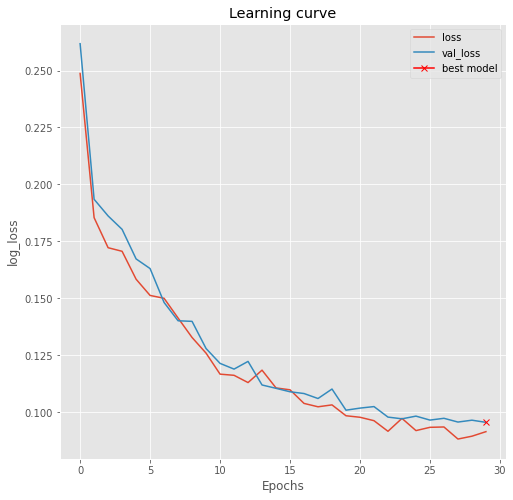

In [27]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_history.history["loss"], label="loss")
plt.plot(model_history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_history.history["val_loss"]), np.min(model_history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

# Training Dice loss and Validation Dice Loss

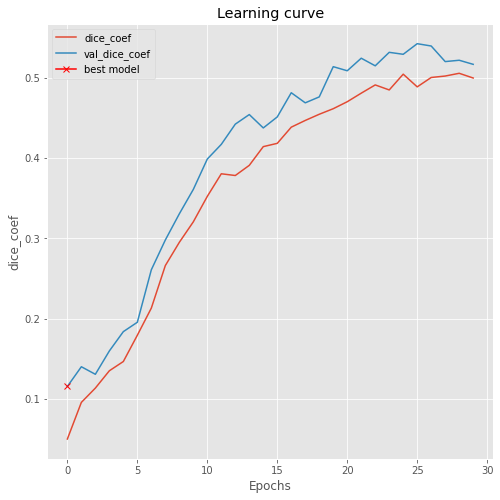

In [28]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_history.history["dice_coef"], label="dice_coef")
plt.plot(model_history.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmin(model_history.history["val_dice_coef"]), np.min(model_history.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();

# Testing on train Data

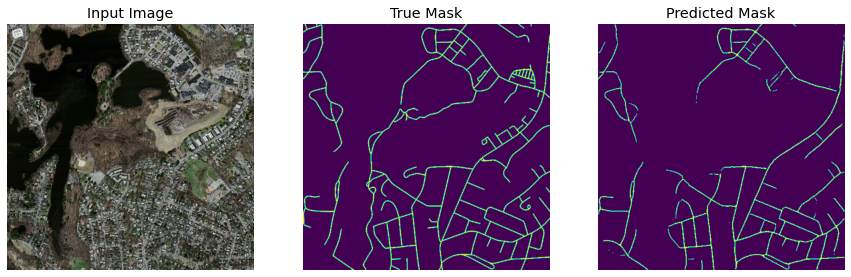

In [29]:
import matplotlib.pyplot as plt
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in training_dataset.take(1):
  sample_image, sample_mask = image, mask
  pred_mask = model.predict(sample_image)
  pred_mask = (pred_mask >= 0.5).astype(np.uint8)

  
display([sample_image[0], sample_mask[0],pred_mask[0]])

# On Test Data

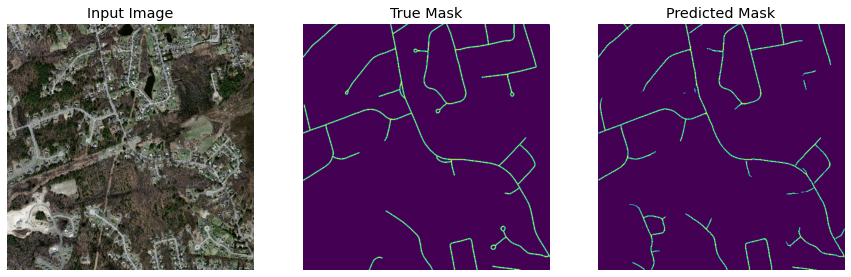

In [30]:
for image, mask in testing_dataset.take(1):
  sample_image, sample_mask = image, mask
  pred_mask = model.predict(sample_image)
  pred_mask = (pred_mask >= 0.5).astype(np.uint8)

display([sample_image[0], sample_mask[0],pred_mask[0]])